In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34, wide_resnet50_2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


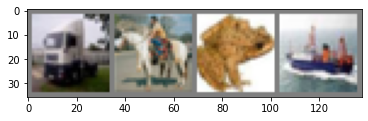

truck horse frog  ship 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_cifar10)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
# net1 = resnet34(weights=None)
# net2 = wide_resnet50_2(weights=None)

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])



In [6]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = MobileNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform_(m.weight, gain=np.sqrt(2))
        init.constant_(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

class wide_basic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(wide_basic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Wide_ResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate, num_classes):
        super(Wide_ResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (depth-4)/6
        k = widen_factor

        print('| Wide-Resnet %dx%d' %(depth, k))
        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0])
        self.layer1 = self._wide_layer(wide_basic, nStages[1], n, dropout_rate, stride=1)
        self.layer2 = self._wide_layer(wide_basic, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(wide_basic, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(int(num_blocks)-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [8]:
net1 = ResNet34()
net2 = MobileNet()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [10]:
def train_model(trainloader, net, criterion, optimizer, epochs, device):
    net.to(device)
    print_interval = int(len(trainloader)/5)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [ ]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_model(trainloader_cifar10, net1, criterion, optimizer1, epochs, device)

In [ ]:
print(device)
train_model(trainloader_cifar10, net2, criterion, optimizer2, epochs, device)

In [11]:
def test_model(testloader, net, device):

    net.to(device)
    correct = 0
    total = 0
    net.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total 
    return acc

In [ ]:
test_model(testloader_cifar10, net1, device)

85.63

In [ ]:
test_model(testloader_cifar10, net2, device)

75.7

In [30]:
'''
Mutual learning function. 
Saves model every 5 epochs to the specified folder.
save_path should be the string containing location to folder.
'''
def mutual_learning(trainloader, net1, net1_name, net2, net2_name, criterion, optimizer1, optimizer2, epochs, device, 
                    save_path, save_model=False):
    net1.to(device)
    net2.to(device)
    print_interval = int(len(trainloader)/5)
    # kl_div = nn.KLDivLoss(reduction="sum")

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss1 = 0.0
        running_loss2 = 0.0
        
        if save_model:
            if epoch % 5 == 4:
                print(f'Saving net1 in folder {net1_name}.')
                torch.save(net1.state_dict(), f'{save_path}/{net1_name}/{epoch+1}.pt')
                print(f'Saving net2 in folder {net2_name}.')
                torch.save(net2.state_dict(), f'{save_path}/{net2_name}/{epoch+1}.pt')
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # forward + backward + optimize
            outputs1 = net1(inputs)
            # print(outputs1)
            outputs2 = net2(inputs)
            # print(outputs2.shape)
            # print(labels.shape)

            loss1 = criterion(outputs1, labels) + F.kl_div(F.softmax(outputs1, dim = 1), F.softmax(outputs2, dim = 1), reduction = 'sum') # add the kl term for mutual learning
            loss1.backward(retain_graph=True)
            optimizer1.step()
            outputs1 = net1(inputs)

            loss2 = criterion(outputs2, labels) + F.kl_div(F.softmax(outputs2, dim = 1), F.softmax(outputs1, dim = 1), reduction = 'sum') 
            loss2.backward()
            optimizer2.step()

            # print statistics
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss1: {running_loss1 / print_interval:.3f}')
                print(f'[{epoch + 1}, {i + 1:5d}] loss2: {running_loss2 / print_interval:.3f}')
                running_loss1 = 0.0
                running_loss2 = 0.0

    print('Finished Training')

In [31]:
epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1_mul = ResNet34()
net2_mul = MobileNet()
net1_name = "resnet_mul_resmob"
net2_name = "mobnet_mul_resmob"
save_path = "/projectnb/dl523/students/paramb/project"
print(device)
optimizer1_mul = optim.SGD(net1_mul.parameters(), lr=0.001, momentum=0.9)
optimizer2_mul = optim.SGD(net2_mul.parameters(), lr=0.001, momentum=0.9)
mutual_learning(trainloader_cifar10, net1_mul, net1_name, net2_mul, net2_name, criterion, optimizer1_mul, optimizer2_mul, epochs, device,
               save_path)

print('mutual net1')
test_model(testloader_cifar10, net1_mul, device)
print('mutual net2')
test_model(testloader_cifar10, net2_mul, device)

cuda


KeyboardInterrupt: 

In [ ]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
resnet_mul = ResNet34()
wide_resnet_mul = Wide_ResNet(28, 10, 0.3, 10)
net1_name = "res_mul_resWideres"
net2_name = "wideres_mul_resWideres"
optimizer_s_mul = optim.SGD(resnet_mul.parameters(), lr=0.001, momentum=0.9)
optimizer_d_mul = optim.SGD(wide_resnet_mul.parameters(), lr=0.001, momentum=0.9)
mutual_learning(trainloader_cifar10, resnet_mul, net1_name, wide_resnet_mul, net2_name, criterion, optimizer_s_mul, optimizer_d_mul, epochs, device,
               save_path, save_model=True)

print('mutual net1 ResNet34')
test_model(testloader_cifar10, resnet_mul, device)
print('mutual net2 WideResNet28-10')
test_model(testloader_cifar10, wide_resnet_mul, device)

| Wide-Resnet 28x10
[1,  2500] loss1: -7.348
[1,  2500] loss2: -5.007


In [ ]:
test_model(testloader_cifar10, net1_mul, device)

85.22

In [ ]:
test_model(testloader_cifar10, net2_mul, device)

76.6

In [19]:
net1_name = "resnet_mul"
print(f'Saving net1 ({net1_name})')

Saving net1 (resnet_mul)
